# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Machine-learning-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Dataset Parameters

In [1]:
num_train = 100000 # Number of images to create for the dataset
num_val = 15000
num_test = 15000
num_bees = 15 # Maximum number of bees to include per image
EX_SUB = 1
version = 1.2

overwrite_feeder = 0
overwrite_BG = 0
overwrite_train = 0
overwrite_validation = 0
overwrite_test = 0

print("Done")

Done


## Library Imports

In [2]:
from GEORGE_Library import *
%matplotlib inline

print("Done")

Using TensorFlow backend
Done


## Feeder Image Array Creation

In [3]:
train_augmented_fp = "Dataset/Custom_Dataset/Train"
val_augmented_fp = "Dataset/Custom_Dataset/Validation"
test_augmented_fp = "Dataset/Custom_Dataset/Test"
feeder_image_fp = "Dataset/Custom_Dataset/FeederImages"
processed_bg_image_fp = "Dataset/Custom_Dataset/ProcessedBGImages"
pi_fp = 'Raspberry_Pi/Images/Training_Bkgnd_Imgs'

if overwrite_feeder:    
    try:
        files = os.listdir(feeder_image_fp)
        for file in files:
            file_path = os.path.join(feeder_image_fp, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    except Exception as e:
        print(e)
        
if overwrite_BG:    
    try:
        files = os.listdir(processed_bg_image_fp)
        for file in files:
            file_path = os.path.join(processed_bg_image_fp, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    except Exception as e:
        print(e)

dataset_paths = {
                 'PD': {'none': {'path': 'Dataset/PollenDataset/Regular', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/PollenDataset/Pollen', 'label': [1, 0, 0]}},
                 'BA': {'none': {'path': 'Dataset/BeeAlarmed/Regular', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/BeeAlarmed/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/BeeAlarmed/Varroa', 'label': [0, 1, 0]},
                        'wasps': {'path': 'Dataset/BeeAlarmed/Wasps', 'label': [0, 0, 1]}},
                }

file_list = []
for dataset_path in dataset_paths:
    for dataset in dataset_paths[dataset_path]:
        [file_list.append(i) for i in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*')]

pi_list = []
[pi_list.append(i) for i in glob.glob(pi_fp + '/*')]

categories = [category(1, "Regular", None), category(2, "Pollen", None), category(3, "Varroa", None), category(4, "Wasps", None)]

print("Done")

Done


## Feeder Image Pre-processing

In [4]:
magic_wand_threshold = 100

existing_files = []
files = os.listdir(feeder_image_fp)
for file in files:
    file_path = os.path.join(feeder_image_fp, file)
    if os.path.isfile(file_path):
        existing_files.append(file_path)

with tqdm(total = len(file_list), unit="image") as pbar:
    for image_id, current_image in enumerate(file_list):        
        Id = image_id + 1
        Image_id = Id

        current_bee = os.path.normpath(file_list[image_id]) # Grab the next feeder image
        category_name = os.path.dirname(current_bee).split('\\')[-1] # Get category of feeder image from containing directory
        Category_id = [i.id for i in categories if i.name == category_name][0]
        File_name = str(Id) + "_" + str(Category_id) + '.png'

        feeder_image_save_fp = feeder_image_fp + '\\' + str(File_name)
        if not feeder_image_save_fp in existing_files:
            image = Image.open(current_image).convert('RGB')
            new_image = deepcopy(image)
    
            if max(image.size) < min(IMAGE_WIDTH, IMAGE_HEIGHT): # Resize feeder image if required
                ind = np.argmax(image.size)
                size = np.zeros(2)
                size[ind] = min(IMAGE_WIDTH, IMAGE_HEIGHT)
                size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                new_image = image.resize((round(size[0]), round(size[1])))
            elif min(image.size) > max(IMAGE_WIDTH, IMAGE_HEIGHT):
                ind = np.argmin(image.size)
                size = np.zeros(2)
                size[ind] = max(IMAGE_WIDTH, IMAGE_HEIGHT)
                size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
                new_image = image.resize((round(size[0]), round(size[1])))
            if np.array(new_image).max() <= 1: # Normalize feeder image if required
                new_image = np.array(new_image) * 255
            new_image = automatic_brightness_and_contrast(np.array(new_image).astype('uint8'))
            if EX_SUB:
                if current_bee.split("\\")[1] == "PollenDataset":
                    img_mode = get_mode(new_image)
                    new_image = cv2.copyMakeBorder(new_image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value= (int(img_mode[0]), int(img_mode[1]), int(img_mode[2])))
                    
                    value_mask = np.ones_like(new_image[:, :, 0]) 
                    for j in range(np.shape(new_image)[1]):
                        # get the indicies of all first and last rows and columns, then pass to new magic wand function and "and" the masks together
                        current_value_mask_top = magic_wand(new_image, (0, j), magic_wand_threshold, contiguous = True)
                        current_value_mask_bottom = magic_wand(new_image, (-1, j), magic_wand_threshold, contiguous = True)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_top)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_bottom)
                    for i in range(np.shape(new_image)[0]):
                        current_value_mask_left = magic_wand(new_image, (i, 0), magic_wand_threshold, contiguous = True)
                        current_value_mask_right = magic_wand(new_image, (i, -1), magic_wand_threshold, contiguous = True)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_left)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_right)
                    
                    new_image = np.dstack((new_image, value_mask * 255))
                    new_image = new_image[1:-1, 1:-1]
                elif current_bee.split("\\")[1] == "BeeAlarmed":
                    img_mode = get_mode(new_image)
                    new_image = cv2.copyMakeBorder(new_image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value= (int(img_mode[0]), int(img_mode[1]), int(img_mode[2])))
                    
                    value_mask = np.ones_like(new_image[:, :, 0]) 
                    for j in range(np.shape(new_image)[1]):
                        # get the indicies of all first and last rows and columns, then pass to new magic wand function and "and" the masks together
                        current_value_mask_top = magic_wand(new_image, (0, j), magic_wand_threshold, contiguous = True)
                        current_value_mask_bottom = magic_wand(new_image, (-1, j), magic_wand_threshold, contiguous = True)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_top)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_bottom)
                    for i in range(np.shape(new_image)[0]):
                        # get the indicies of all first and last rows and columns, then pass to new magic wand function and "and" the masks together
                        current_value_mask_left = magic_wand(new_image, (i, 0), magic_wand_threshold, contiguous = True)
                        current_value_mask_right = magic_wand(new_image, (i, -1), magic_wand_threshold, contiguous = True)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_left)
                        value_mask = cv2.bitwise_and(value_mask, current_value_mask_right)
                    
                    new_image = np.dstack((new_image, value_mask * 255))
                    new_image = new_image[1:-1, 1:-1]
            Image.fromarray(np.array(new_image).astype('uint8')).save(feeder_image_save_fp, "PNG")
        pbar.update(1)

print("Done")

100%|████████████████████████████████████████████████████████████████████████| 7187/7187 [00:00<00:00, 21748.47image/s]

Done


## Background Image Pre-processing

In [5]:
img_width = 640
img_height = 640

if overwrite_BG:
    with tqdm(total = len(pi_list), unit="image") as pbar:
        for idx, image in enumerate(pi_list):
            for i in range(2):
                BG_img = Image.open(random.choice(pi_list)).convert('RGB')
                BG_img = automatic_brightness_and_contrast(np.array(BG_img).astype('uint8'))
                BG_height, BG_width, _ = BG_img.shape
                left = img_width * i
                bottom =  int(BG_height - ((BG_height - img_height) / 2))
                right = img_width * (i + 1)
                top = int((BG_height - img_height) / 2)
                BG_img = Image.fromarray(BG_img).crop((left, top, right, bottom))
        
                BG_img.save(processed_bg_image_fp + '/' + str(idx) + "_" + str(i) + ".png", "PNG")
            pbar.update(1)

print("Done")

Done


## Training Dataset Creation Loop

In [6]:
# NOTE: COCO Dataset IDs start with 1

feeder_image_file_list = []
[feeder_image_file_list.append(i) for i in glob.glob(feeder_image_fp + '/*')]

bg_list = []
[bg_list.append(i) for i in glob.glob(processed_bg_image_fp + '/*')]

images = []
annotations = []
licenses = []

# License creation "loop"
License_Id = 1
Name = 'Attribution-NonCommercial-ShareAlike 4.0 International'
Url = 'https://creativecommons.org/licenses/by-nc-sa/4.0/'
licenses.append(license(License_Id, Name, Url))

License = 1
Flickr_url = None
Coco_url = None
# Annotation_Id = 1

def dataset_creation_loop(num_images, augmented_fp, overwrite = False):
    if overwrite:
        try:
            files = os.listdir(augmented_fp)
            for file in files:
                file_path = os.path.join(augmented_fp, file)
                if os.path.isfile(file_path):
                    os.remove(file_path)
        except Exception as e:
            print(e)
    
    existing_files = []
    files = os.listdir(augmented_fp)
    for file in files:
        file_path = os.path.join(augmented_fp, file)
        if os.path.isfile(file_path):
            existing_files.append(file_path)

    existing_num_images = len(existing_files)
    Annotation_Id = 1
    with tqdm(total = num_images - existing_num_images, unit="image") as pbar:
        for image_id in range(num_images - existing_num_images):
            BG_img = Image.open(random.choice(bg_list)).convert('RGB')
            
            Id = image_id + 1
            File_name = str(Id) + '.png'
            Date_captured = str(datetime.now())
            
            # Feeder image usage sub-loop (annotation sub-loop)
            for bee in range(random.randint(1, num_bees)): # number of bees to include in image
                Image_id = Id
        
                current_bee = os.path.normpath(random.choice(feeder_image_file_list)) # Grab a random bee from feeder images
                Category_id = int(os.path.basename(current_bee).split('_')[-1].split('.png')[0])
                category_name = [i.name for i in categories if i.id == Category_id][0] # Get category of feeder image from containing directory

                image = Image.open(current_bee).convert('RGBA')
                new_image = deepcopy(image)
                new_image = zoom_image(new_image, 0.5) # second argument is zoom factor
                new_image = brightness_match(BG_img, new_image)
                new_image = random_motion_blur(new_image)
                BG_img, new_coords = process_image(np.array(new_image).astype('uint8'), BG_img)
                new_coords = new_coords * 640 # ideally need to put this in terms of desired img size
                str_name = []
                for coord in new_coords:
                    str_name.append(str(coord).split('.')[1])
        
                Segmentation = None
                X = new_coords[1]
                Y = new_coords[0]
                Width = new_coords[3] - X
                Height = new_coords[2] - Y
                Area = Width * Height
                Bbox = bbox(X, Y, Width, Height)
                Iscrowd = 0 # Pretty sure this is perpetually zero for this dataset
                
                annotations.append(annotation(Annotation_Id, Image_id, Category_id, Segmentation, Area, Bbox, Iscrowd))
                Annotation_Id = Annotation_Id + 1

            BG_img = automatic_brightness_and_contrast(np.array(BG_img).astype('uint8'))
            BG_img = automatic_saturation(BG_img)
            # BG_img = automatic_tint(BG_img)
            Image.fromarray(BG_img).save(augmented_fp + '/' + str(File_name),"PNG")
            images.append(img(Id, img_width, img_height, File_name, License, Flickr_url, Coco_url, Date_captured))
            pbar.update(1)

dataset_creation_loop(num_train, train_augmented_fp, overwrite = overwrite_train)

if overwrite_train:
    info = {
            "year": str(datetime.now().year),
            "version": version,
            "description": "GEORGE Custom Training Dataset",
            "contributor": "Kevin Hardin",
            "url": "https://www.kaggle.com/datasets/kevinhardin/george-augmented-dataset",
            "date_created": str(datetime.now()),
            }
    
    with open(train_augmented_fp + "/custom_bee_dataset.json", "w") as outfile:
        json.dump({"info": info, "images": [json.loads(i.toJSON()) for i in images], "annotations": [json.loads(i.toJSON()) for i in annotations], "licenses": [json.loads(i.toJSON()) for i in licenses], "categories": [json.loads(i.toJSON()) for i in categories]}, outfile, indent = 4)

print("Done")

0image [00:00, ?image/s]

Done


## Validation Dataset Creation Loop

In [7]:
images = []
annotations = []
licenses = []

dataset_creation_loop(num_val, val_augmented_fp, overwrite = overwrite_validation)

if overwrite_validation:
    info = {
            "year": str(datetime.now().year),
            "version": version,
            "description": "GEORGE Custom Validation Dataset",
            "contributor": "Kevin Hardin",
            "url": "https://www.kaggle.com/datasets/kevinhardin/george-augmented-dataset",
            "date_created": str(datetime.now()),
            }
    
    with open(val_augmented_fp + "/custom_bee_dataset.json", "w") as outfile:
        json.dump({"info": info, "images": [json.loads(i.toJSON()) for i in images], "annotations": [json.loads(i.toJSON()) for i in annotations], "licenses": [json.loads(i.toJSON()) for i in licenses], "categories": [json.loads(i.toJSON()) for i in categories]}, outfile, indent = 4)

print("Done")

0image [00:00, ?image/s]

Done


## Test Dataset Creation Loop

In [8]:
images = []
annotations = []
licenses = []

dataset_creation_loop(num_test, test_augmented_fp, overwrite = overwrite_test)

if overwrite_test:
    info = {
            "year": str(datetime.now().year),
            "version": version,
            "description": "GEORGE Custom Test Dataset",
            "contributor": "Kevin Hardin",
            "url": "https://www.kaggle.com/datasets/kevinhardin/george-augmented-dataset",
            "date_created": str(datetime.now()),
            }
    
    with open(test_augmented_fp + "/custom_bee_dataset.json", "w") as outfile:
        json.dump({"info": info, "images": [json.loads(i.toJSON()) for i in images], "annotations": [json.loads(i.toJSON()) for i in annotations], "licenses": [json.loads(i.toJSON()) for i in licenses], "categories": [json.loads(i.toJSON()) for i in categories]}, outfile, indent = 4)

print("Done")

0image [00:00, ?image/s]

Done


## Visualization

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



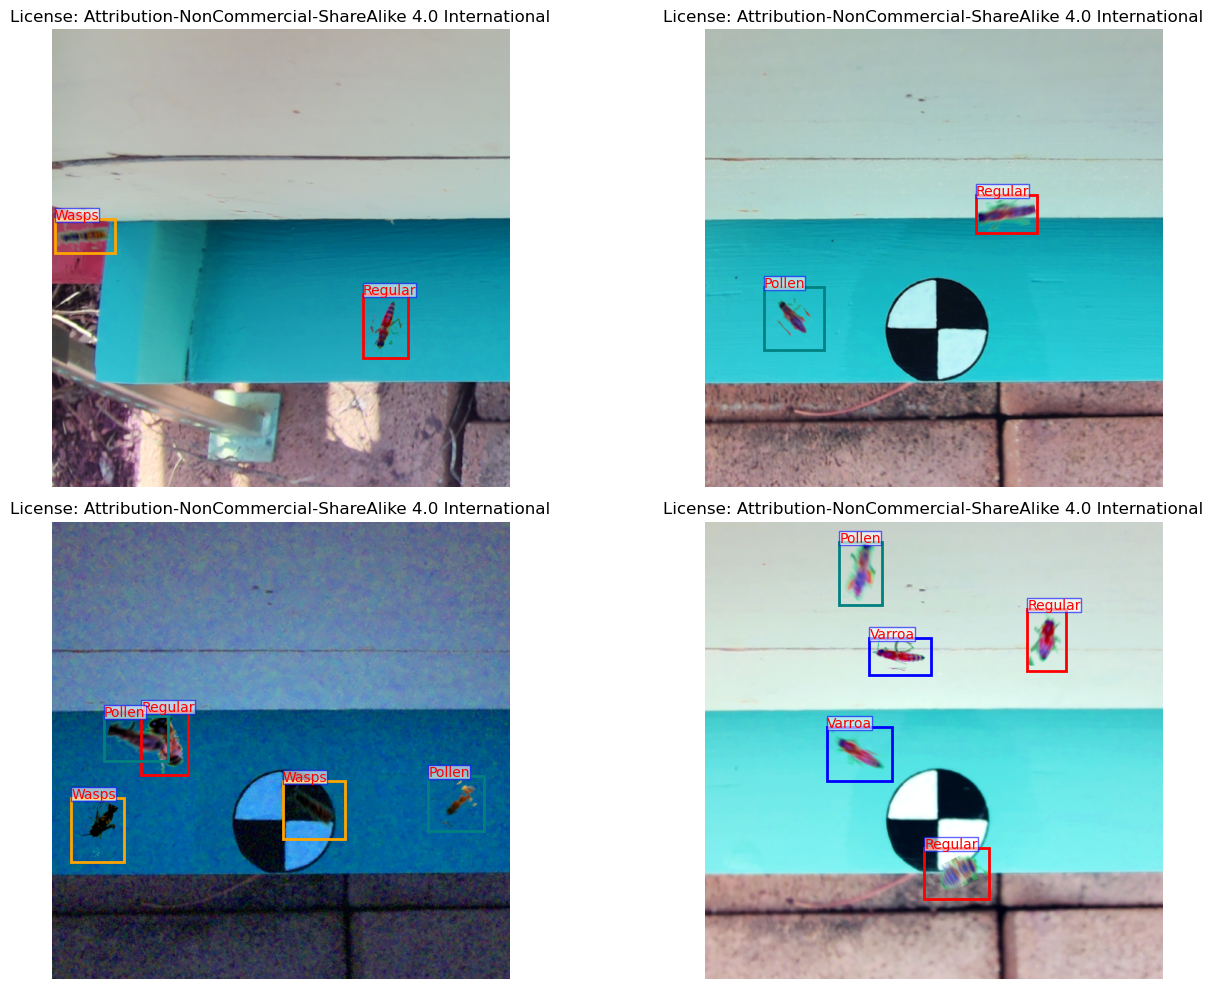

In [9]:
coco_annotations_file = train_augmented_fp + "/custom_bee_dataset.json"
with open(coco_annotations_file, 'r') as f:
    print(json.load(f))
coco = COCOParser(coco_annotations_file, train_augmented_fp)

# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"] * 10
num_imgs_to_disp = 4
img_ids = coco.get_imgIds()
total_images = len(img_ids) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{train_augmented_fp}/{str(im).zfill(0)}.png")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        _bbox = ann['bbox']
        x, y, w, h = [int(b) for b in _bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        _license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth = 2, edgecolor = color_, facecolor = 'none')
        t_box=ax[i].text(x, y, class_name,  color = 'red', fontsize = 10)
        t_box.set_bbox(dict(boxstyle = 'square, pad=0',facecolor = 'white', alpha = 0.6, edgecolor = 'blue'))
        ax[i].add_patch(rect)
    
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {_license}")
plt.tight_layout()
plt.show()